---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Heiner Mauricio Obando Vega**
* Carné: **B55130**
* Grupo: **1**

---
# `P4` - *Modulación digital IQ*

---
## 4. - Asignaciones del proyecto

### 4.1. - Modulación QPSK

* (50%) Realice una simulación del sistema de comunicaciones como en la sección 3.2., pero utilizando una modulación QPSK en lugar de una modulación BPSK. Deben mostrarse las imágenes enviadas y recuperadas y las formas de onda.

Duración de la simulación:  4.995757818222046
0 errores, para un BER de 0.0000.


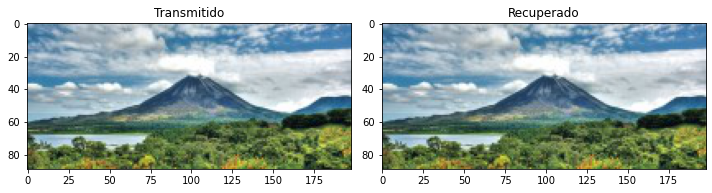

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

# Extracción de los pixeles de una imagen 

def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

# -----------------------------------------------------------------------
# Codificación de pixeles a una base binaria (bits)

def rgb_a_bit(imagen):
    '''Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

# -----------------------------------------------------------------------
# Etapa de modulación

def modulador(bits, fc, mpp):
    '''Un método que simula el esquema de 
    modulación digital BPSK.

    :param bits: Vector unidimensional de bits
    :param fc: Frecuencia de la portadora en Hz
    :param mpp: Cantidad de muestras por periodo de onda portadora
    :return: Un vector con la señal modulada
    :return: Un valor con la potencia promedio [W]
    :return: La onda portadora c(t)
    :return: La onda cuadrada moduladora (información)
    '''
    # Parámetros de la 'señal' de información (bits)
    bits_matriz = bits.reshape(len(bits) // 2, 2)
    
    # Cantidad de bits
    N = len(bits_matriz)
    
    # Construyendo un periodo de las señales de las dos portadoras
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    portadora_I = np.cos(2*np.pi*fc*t_periodo)
    portadora_Q = np.sin(2*np.pi*fc*t_periodo)

    # Inicializar la señal modulada s(t) y las señales de las dos portadoras
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Tx_I = np.zeros(t_simulacion.shape)
    senal_Tx_Q = np.zeros(t_simulacion.shape)
    senal_Tx = np.zeros(t_simulacion.shape)
    
    
    # Asignar las formas de onda según los bits (QPSK) 
    for i, bit in enumerate(bits_matriz):
        
        if bits_matriz[i,0] == 1:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I
            
        else:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I * -1
            
        if bits_matriz[i,1] == 1:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q
            
        else:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q * -1
    
    # Se obtiene la señal modulada a partir de las señales obtenidas de las dos portadoras
    senal_Tx = senal_Tx_I + senal_Tx_Q
    
    # Calcular la potencia promedio de la señal modulada
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm, portadora_I, portadora_Q, bits_matriz

# -------------------------------------------------------------------------------------
# Construcción de un canal con ruido

def canal_ruidoso(senal_Tx, Pm, SNR):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso) empleando ruido
    AWGN. Pide por parámetro un vector con la
    señal provieniente de un modulador y un
    valor en decibelios para la relación señal
    a ruido.

    :param senal_Tx: El vector del modulador
    :param Pm: Potencia de la señal modulada
    :param SNR: Relación señal-a-ruido en dB
    :return: La señal modulada al dejar el canal
    '''
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

# --------------------------------------------------------------------------------------
# Etapa de demodulación

def demodulador(senal_Rx, portadora_I, portadora_Q, mpp):
    '''Un método que simula un bloque demodulador
    de señales, bajo un esquema BPSK. El criterio
    de demodulación se basa en decodificación por 
    detección de energía.

    :param senal_Rx: La señal recibida del canal
    :param portadora: La onda portadora c(t)
    :param mpp: Número de muestras por periodo
    :return: Los bits de la señal demodulada
    '''
    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vectores para bits obtenidos por la demodulación
    bits_Rx_I = np.zeros(N)
    bits_Rx_Q = np.zeros(N)
    bits_Rx = np.zeros(2*N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto_I = senal_Rx[i*mpp : (i+1)*mpp] * portadora_I
        producto_Q = senal_Rx[i*mpp : (i+1)*mpp] * portadora_Q
        Ep_I = np.sum(producto_I)
        Ep_Q = np.sum(producto_Q)
        senal_demodulada[i*mpp : (i+1)*mpp] = producto_I + producto_Q
         
        # Criterio de decisión por detección de energía  
        if Ep_I > 0:
            bits_Rx_I[i] = 1
        else:
            bits_Rx_I[i] = 0
            
        if Ep_Q > 0:
            bits_Rx_Q[i] = 1
        else:
            bits_Rx_Q[i] = 0
            
    # Se realizan los siguientes for para hacer llegar los bits en el orden que fueron tomados por las portadoras      
    for j, bits_I in enumerate(bits_Rx_I):
        bits_Rx[2*j] = bits_I 
        
    for k, bits_Q in enumerate(bits_Rx_Q):
        bits_Rx[2*k+1] = bits_Q
            
    return bits_Rx.astype(int), senal_demodulada

# -----------------------------------------------------------------------------------------
# Reconstrucción de la imagen

def bits_a_rgb(bits_Rx, dimensiones):
    '''Un blque que decodifica el los bits
    recuperados en el proceso de demodulación

    :param: Un vector de bits 1 x k 
    :param dimensiones: Tupla con dimensiones de la img.
    :return: Un array con los pixeles reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

# -----------------------------------------------------------------------------------------
# Simulación de transmisión de la imagen

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora_I, portadora_Q, bits_matriz = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora_I, portadora_Q, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

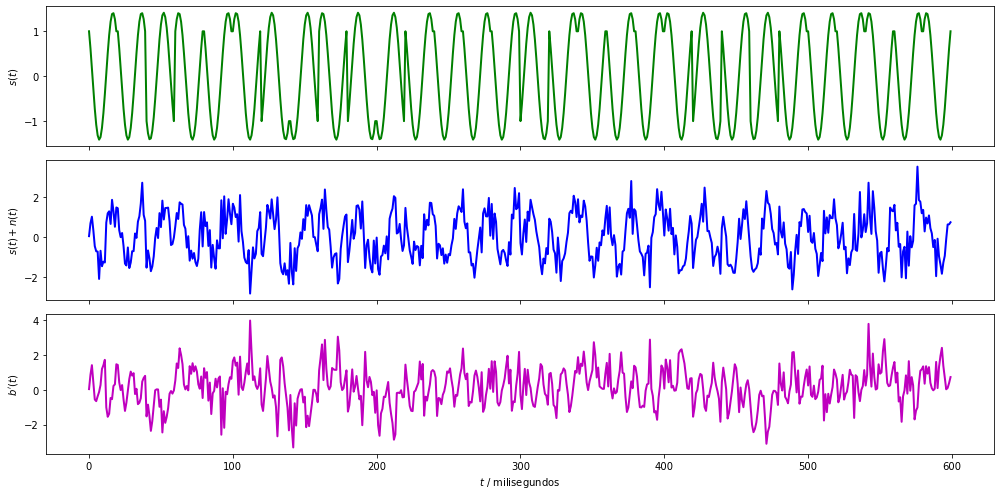

In [2]:
# Gráficas de las señales generadas en la transmisión de la imagen
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))

# La señal modulada por BPSK
ax1.plot(senal_Tx[0:600], color='g', lw=2) 
ax1.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax2.plot(senal_Rx[0:600], color='b', lw=2) 
ax2.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax3.plot(senal_demodulada[0:600], color='m', lw=2) 
ax3.set_ylabel('$b^{\prime}(t)$')
ax3.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()

### 4.2. - Estacionaridad y ergodicidad

* (30%) Realice pruebas de estacionaridad y ergodicidad a la señal modulada `senal_Tx` y obtenga conclusiones sobre estas.

C:\Users\Usuario\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


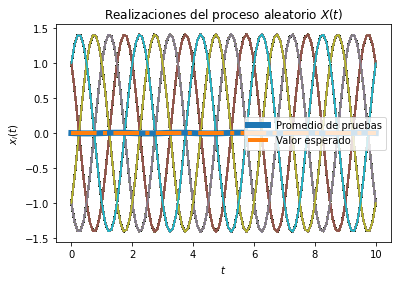

In [14]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# Promedio de la amplitud
p = 1/2

# Se inicializan las variables aleatorias, se trabaja con bernoulli ya que esta distribución solo trabaja con dos diferentes valores
x1 = bernoulli(p)
x2 = bernoulli(p)

#Parámetros
fc = 5000 # frecuencia de la portadora
mpp = 20 #muestras por periodo de la portadora
Tc = 1 / fc # periodo [s]

# Creación del vector de tiempo
T = 100			# número de elementos
t_final = 10	# tiempo en segundos
t = t = np.linspace(0, t_final, T)


# Inicialización del proceso aleatorio X(t) con N realizaciones
N = 100000
X_t = np.empty((N, len(t)))	# N funciones del tiempo x(t) con T puntos

# Creación de las muestras del proceso x(t) (A y Z independientes)
for i in range(N):
    A = x1.rvs()
    if A == 0: # Se realizan los if para cambiar los valores de 0 por -1, ya que la distribución Bernoulli se mueve entre 0 y 1
        A = -1
    else:
        A = 1  

    Z = x2.rvs()
    if Z == 0:
        Z = -1
    else:
        Z = 1 
        
    x_t = A * np.cos(2*np.pi*fc*t) + Z * np.sin(2*np.pi*fc*t)
    X_t[i,:] = x_t
    plt.plot(t, x_t)  

# Promedio de las N realizaciones en cada instante (cada punto en t)
P = [np.mean(X_t[:,i]) for i in range(len(t))]
plt.plot(t, P, lw=6, label = 'Promedio de pruebas')

# Graficar el resultado teórico del valor esperado, obtenido por la señal_Tx
E = [np.mean(senal_Tx) for i in range(len(t))]
plt.plot(t, E, '-.', lw=4, label = 'Valor esperado')

# Mostrar las realizaciones, y su promedio calculado y teórico
plt.title('Realizaciones del proceso aleatorio $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$x_i(t)$')
plt.legend()
plt.show()

### 4.3. - Densidad espectral de potencia

* (20%) Determine y grafique la densidad espectral de potencia para la señal modulada `senal_Tx`.

<ipython-input-11-e25398a6d098>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


----------
Densidad espectral de potencia para la señal modulada
----------
[1.79077924e+08 5.79900636e+08 2.05178163e+06 ... 4.25394824e+06
 2.05178163e+06 5.79900636e+08]
----------



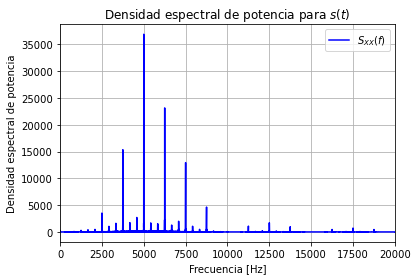

In [11]:
from scipy import fft

# Transformada de Fourier 
senal_f = fft(senal_Tx)

# Muestras de la señal
Nm = len(senal_Tx)

# Número de símbolos (con // entrega un número entero)
#(198 x 89 x 8 x 3)
Ns = Nm // mpp

# Tiempo del símbolo
Ts = 1 / fc

# Tiempo entre muestras (período de muestreo)
Tm = Ts / mpp

# Tiempo de la simulación
T = Ns * Ts

# Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm), Nm//2)

# Densidad espectral de potencia
S_xx = np.power(np.abs(senal_f), 2)


print('----------\nDensidad espectral de potencia para la señal modulada\n----------')
print(S_xx)
print('----------\n')

# Se Grafica la densidad espectral de potencia
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2), color = 'blue' , label='$S_{XX}(f)$')
plt.xlim(0, 20000)
plt.title('Densidad espectral de potencia para $s(t)$')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.legend()
plt.grid()
plt.show()